In [1]:
import muon as mu
from muon import atac as ac
import numpy as np
import scanpy as sc
import episcanpy as epi

In [2]:
rna = sc.read_h5ad("/ailab/user/sunjianle-hdd/integration27/mop/Yao-2021-RNA.h5ad")
atac = sc.read_h5ad("/ailab/user/sunjianle-hdd/integration27/mop/Yao-2021-ATAC.h5ad")

In [3]:
rna

AnnData object with n_obs × n_vars = 69727 × 27123
    obs: 'x', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'aggr_num', 'umi.counts', 'gene.counts', 'library_id', 'tube_barcode', 'Seq_batch', 'Region', 'Lib_type', 'Gender', 'Donor', 'Amp_Name', 'Amp_Date', 'Amp_PCR_cyles', 'Lib_Name', 'Lib_Date', 'Replicate_Lib', 'Lib_PCR_cycles', 'Lib_PassFail', 'Cell_Capture', 'Lib_Cells', 'Mean_Reads_perCell', 'Median_Genes_perCell', 'Median_UMI_perCell', 'Saturation', 'Live_percent', 'Total_Cells', 'Live_Cells', 'method', 'exp_component_name', 'mapped_reads', 'unmapped_reads', 'nonconf_mapped_reads', 'total.reads', 'doublet.score', 'domain', 'protocol', 'dataset', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_type', 'gene_name', 'mgi_id', 'havana_gene', 'tag', 'n_counts', 'highly_variable', 'highly_variable_

In [38]:
atac

AnnData object with n_obs × n_vars = 54844 × 148814
    obs: 'sample', 'barcode', 'TN', 'UM', 'PP', 'UQ', 'CM', 'tsne_0', 'tsne_1', 'cluster', 'region', 'MajorCluster', 'SubCluster', 'domain', 'protocol', 'dataset', 'cell_type', 'batch'
    var: 'chrom', 'chromStart', 'chromEnd', 'genome', 'n_counts'

In [40]:
atac.X.toarray()

array([[0., 1., 1., ..., 0., 2., 1.],
       [2., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

deal with scRNA data

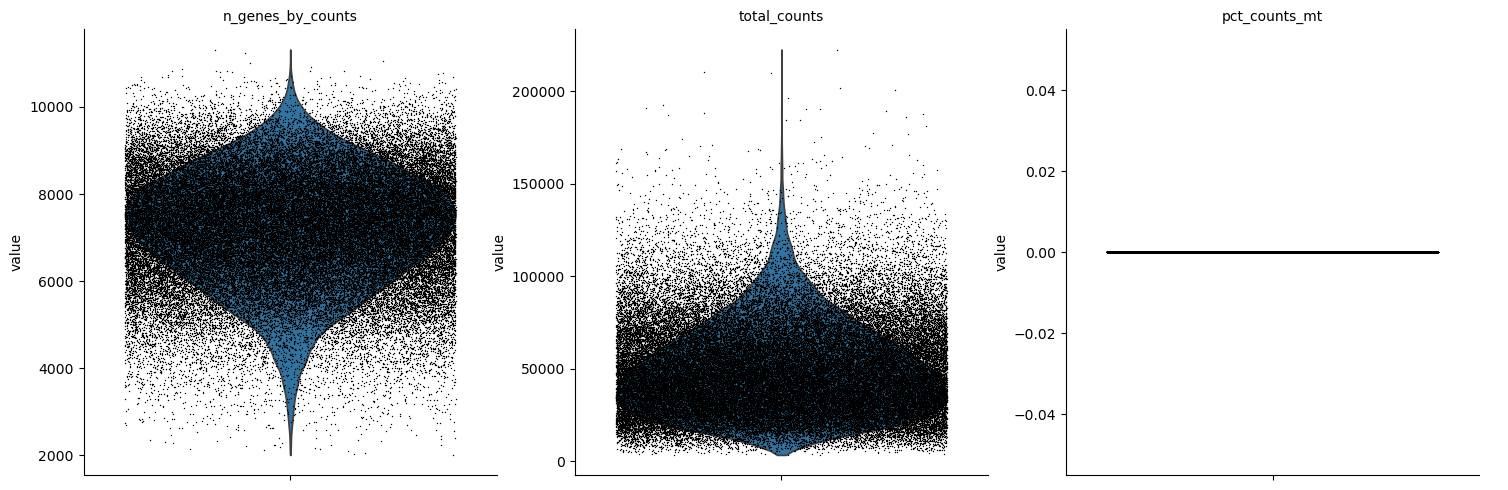

In [5]:
rna.var['mt'] = rna.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(rna, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [6]:
# mu.pp.filter_var(rna, 'n_cells_by_counts', lambda x: x >= 3)
# mu.pp.filter_obs(rna, 'n_genes_by_counts', lambda x: (x >= 200) & (x < 5000))
# mu.pp.filter_obs(rna, 'total_counts', lambda x: x < 15000)
# mu.pp.filter_obs(rna, 'pct_counts_mt', lambda x: x < 20)

# sc.pp.filter_genes(rna, min_cells=3)
# sc.pp.filter_cells(rna, min_genes=200)
# sc.pp.filter_cells(rna, max_genes=5000)
# sc.pp.filter_cells(rna, max_counts=15000)
# rna = rna[rna.obs['pct_counts_mt'] < 20, :]
rna.layers['counts'] = rna.X.copy()

In [8]:
rna.obs['batch'] = rna.obs.Seq_batch

In [9]:
sc.pp.normalize_total(rna)
sc.pp.log1p(rna)
sc.pp.highly_variable_genes(rna, batch_key="batch", min_mean=0.02, max_mean=4, min_disp=0.5)
genelist = rna.var.index[rna.var['highly_variable']==True]

deal with scATAC data

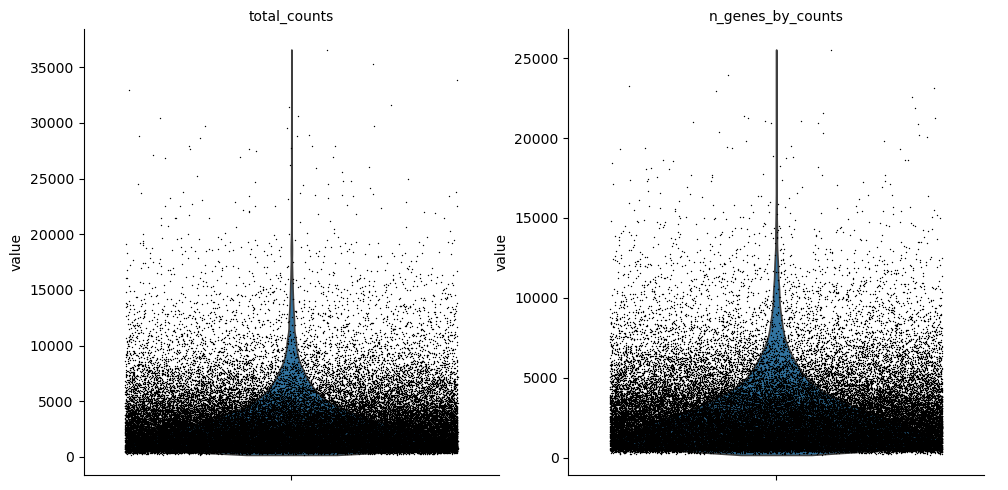

In [3]:
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)
sc.pl.violin(atac, ['total_counts', 'n_genes_by_counts'], jitter=0.4, multi_panel=True)

In [4]:
# mu.pp.filter_var(atac, 'n_cells_by_counts', lambda x: x >= 10)
# mu.pp.filter_obs(atac, 'n_genes_by_counts', lambda x: (x >= 2000) & (x <= 15000))

# sc.pp.filter_genes(atac, min_cells=10)
# sc.pp.filter_cells(atac, min_genes=2000)
# sc.pp.filter_cells(atac, max_genes=15000)
atac.layers["counts"] = atac.X.copy()

In [5]:
ac.pp.tfidf(atac, scale_factor=1e4)
sc.pp.highly_variable_genes(atac, batch_key="batch") #, min_mean=0.05, max_mean=1.5, min_disp=.5
peaklist = atac.var.index[atac.var['highly_variable']==True]

In [6]:
atac.write_h5ad("/ailab/user/sunjianle-hdd/integration27/mop/Yao/ATAC_counts_qc.h5ad")

combine data

In [13]:
# data after QC
rna.write_h5ad("/ailab/user/sunjianle-hdd/integration27/mop/Yao/RNA_counts_qc.h5ad")
atac.write_h5ad("/ailab/user/sunjianle-hdd/integration27/mop/Yao/ATAC_counts_qc.h5ad")

In [14]:
atac = sc.read("/ailab/user/sunjianle-hdd/integration27/mop/Yao/ATAC_counts_qc.h5ad")
atac.layers['normalized'] = atac.X.copy()
atac.X = atac.layers['counts'].copy()
atac_gas = epi.tl.geneactivity(atac, "/ailab/user/sunjianle-hdd/integration27/BMMC/gencode.vM10.chr_patch_hapl_scaff.annotation.gtf",annotation='HAVANA')
atac_gas = atac_gas[:, ~atac_gas.var_names.duplicated()]

In [15]:
atac_gas.layers['counts'] = atac_gas.X.copy()
# ac.pp.tfidf(atac_gas, scale_factor=1e4)
sc.pp.normalize_total(atac_gas)
sc.pp.log1p(atac_gas)
sc.pp.highly_variable_genes(atac_gas, batch_key="batch", min_mean=0.02, max_mean=4, min_disp=0.5) #, min_mean=0.05, max_mean=1.5, min_disp=.5
peaklist = atac_gas.var.index[atac_gas.var['highly_variable']==True]

In [16]:
atac_gas.write("/ailab/user/sunjianle-hdd/integration27/mop/Yao/ATAC_gas.h5ad")

In [17]:
rna = sc.read("/ailab/user/sunjianle-hdd/integration27/mop/Yao/RNA_counts_qc.h5ad")
genelist = rna.var.index[rna.var['highly_variable']==True]
genelist2 = list((set(peaklist) | set(genelist)) & set(atac_gas.var_names) & set(rna.var_names))

In [18]:
len(genelist2)

3154

In [19]:
genelist3 = list((set(peaklist) & set(genelist)) & set(atac_gas.var_names) & set(rna.var_names))
len(genelist3)

412

In [20]:
import anndata as ad
adata = ad.concat([rna,atac_gas], join='inner', label="modality")
adata

AnnData object with n_obs × n_vars = 124571 × 15637
    obs: 'domain', 'protocol', 'dataset', 'cell_type', 'n_genes_by_counts', 'total_counts', 'batch', 'modality'
    layers: 'counts'

In [21]:
adata.obs.batch.unique()

['RTX-841', 'RTX-842', 'RTX-850', 'CEMBA171206_3C', 'CEMBA171207_3C', ..., 'CEMBA180104_4B', 'CEMBA180409_2C', 'CEMBA180410_2C', 'CEMBA180612_5D', 'CEMBA180618_5D']
Length: 12
Categories (12, object): ['CEMBA171206_3C', 'CEMBA171207_3C', 'CEMBA171212_4B', 'CEMBA171213_4B', ..., 'CEMBA180618_5D', 'RTX-841', 'RTX-842', 'RTX-850']

In [22]:
adata.uns['rna_hvg'] = genelist.to_list()
adata.uns['atac_hvg'] = peaklist.to_list()

In [23]:
adata[:,genelist2].write("/ailab/user/sunjianle-hdd/integration27/mop/Yao/feature_aligned.h5ad")

In [7]:
atac_gas = sc.read_h5ad("/ailab/user/sunjianle-hdd/integration27/mop/Yao/ATAC_gas.h5ad")
atac_gas

AnnData object with n_obs × n_vars = 54844 × 20545
    obs: 'sample', 'barcode', 'TN', 'UM', 'PP', 'UQ', 'CM', 'tsne_0', 'tsne_1', 'cluster', 'region', 'MajorCluster', 'SubCluster', 'domain', 'protocol', 'dataset', 'cell_type', 'batch', 'n_genes_by_counts', 'total_counts'
    var: 'level', 'tag', 'gene_id', 'annotation', 'gene_type', 'havana_gene', 'gene_status', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'log1p'
    layers: 'counts'

In [9]:
np.max(atac_gas.layers['counts'])

510.0